<a href="https://colab.research.google.com/github/z-guard/analysis/blob/main/notebooks/library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 図書館・書店
- input:
    - [図書館](https://catalog.data.metro.tokyo.lg.jp/dataset/t000021d2000000003/resource/7108f0a3-0257-424a-9722-e84999a01392)
        - 図書館の位置
    - various_shops_master
        - 書店の位置
- output:
    - library_score.csv
        - 図書館スコア

In [1]:
!pip install -q japanize-matplotlib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
DIR_NAME = '/content/drive/MyDrive/z-gard/data'

In [4]:
output_master_file = 'library_master.csv'
output_score_file = 'library_score.csv'

In [5]:
import os
import requests
import json
import pandas as pd
import numpy as np
from urllib.parse import urlparse
import math
import io
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [6]:
def get_data_csv_url(url, encoding='utf-8', excel=False):
    res = requests.get(url)
    if res.status_code == 200:
        if not excel:
            return pd.read_csv(io.BytesIO(res.content), encoding=encoding)
        else:
            return pd.read_excel(io.BytesIO(res.content))
    else:
        raise Exception(f'status_code: {res.status_code} ({url})')

# 距離計算
def get_distance(lat1, lon1, lat2, lon2):
    _lat1 = lat1 * math.pi / 180
    _lon1 = lon1 * math.pi / 180
    _lat2 = lat2 * math.pi / 180
    _lon2 = lon2 * math.pi / 180
    _tmp = math.cos(_lat1) * math.cos(_lat2) * math.cos(_lon2 - _lon1) + math.sin(_lat1) * math.sin(_lat2)
    _tmp = 1 if _tmp > 1 else -1 if _tmp < -1 else _tmp
    return 6371 * math.acos(_tmp)

# 最寄り施設までの距離
def get_value_of_nearest_facility(df_master, df_facility, category, method='min', param=3):
    _df_cat = df_facility[df_facility['施設分類'] == category].copy()
    cat_values = []
    for i, (lat, lon) in enumerate(zip(df_master['緯度'].values, df_master['経度'].values)):
        dist = _df_cat[
            ((_df_cat['緯度'] - lat).abs() < 0.04) &    # 約4km以内
            ((_df_cat['経度'] - lon).abs() < 0.04)      # 約4km以内
        ].apply(lambda x: get_distance(x['緯度'], x['経度'], lat, lon), axis=1)
        val = np.NaN
        if len(dist) > 0:
            if method == 'min':
                # 最小の距離
                val = dist.min()
            elif method == 'count':
                # {param}km以内の施設の数をカウント
                val = len(dist[dist <= param])
            elif method == 'mean':
                # 近い{param}件の距離の平均
                val = dist.sort_values()[:param].mean()
        else:
            print(f'{category} not found {i}')
        cat_values.append(val)
    return cat_values

In [7]:
def get_distance_from_facility(longitude, latitude, df_facility):
    return df_facility.apply(lambda x: get_distance(x['緯度'], x['経度'], longitude, latitude), axis=1)

In [8]:
extract_columns = ['施設分類', '名称', '市区町村名', '所在地', '緯度', '経度']

In [9]:
tokyo_library_url = 'https://www.opendata.metro.tokyo.lg.jp/kyouiku/R3/skshubetu_4.csv'
df_tokyo_library = get_data_csv_url(tokyo_library_url, encoding='shift-jis')
print(df_tokyo_library.shape)

df_tokyo_library = df_tokyo_library[df_tokyo_library['施設名'].notna()]
df_tokyo_library = df_tokyo_library[(~df_tokyo_library['施設名'].str.contains('閉館'))&(df_tokyo_library['区市町村名'].str.endswith('区'))]
df_tokyo_library['施設名'] = df_tokyo_library['施設名'].str.replace('＊\?', '', regex=True).str.replace('\?\?', '', regex=True)
df_tokyo_library = df_tokyo_library.rename(columns={'施設区分':'施設分類', '施設名':'名称', '区市町村名':'市区町村名'})[extract_columns].reset_index(drop=True)
print(df_tokyo_library.shape)

(418, 9)
(233, 6)


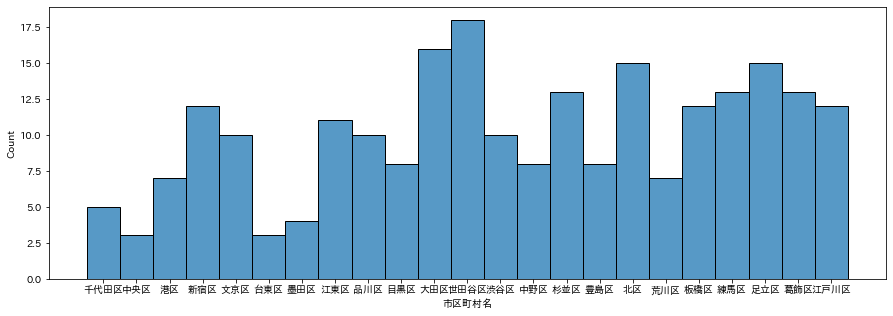

In [10]:
plt.figure(figsize=(15, 5))
sns.histplot(x='市区町村名', data=df_tokyo_library)
plt.show()

### 図書館マスタ

In [11]:
df_library_master = df_tokyo_library
print(df_library_master.shape)
df_library_master.head()

(233, 6)


,施設分類,名称,市区町村名,所在地,緯度,経度
0,図書館,昌平まちかど図書館,千代田区,千代田区外神田3-4-7,35.701223,139.769873
1,図書館,神田まちかど図書館,千代田区,千代田区神田司町2-16,35.693357,139.768304
2,図書館,四番町図書館,千代田区,千代田区四番町1,35.690453,139.741601
3,図書館,千代田図書館,千代田区,千代田区九段南1-2-1千代田区役所9･10階,35.693997,139.753585
4,図書館,日比谷図書文化館,千代田区,千代田区日比谷公園1-4,35.671872,139.754602


In [12]:
df_library_master.to_csv(os.path.join(DIR_NAME, output_master_file), index=False)

### 書店

In [13]:
df_various_store = pd.read_csv(os.path.join(DIR_NAME, 'various_shops_master.csv')).drop(columns=['住所', 'rating'])
df_book_store = df_various_store[df_various_store['施設分類'] == '本DVD'].reset_index(drop=True)
print(df_book_store.shape)

(913, 4)


In [14]:
df_library_book = pd.concat([
    df_library_master,
    df_book_store
]).reset_index(drop=True)
print(df_library_book.shape)

(1146, 6)


### 地理マスタ

In [15]:
df_geo_master = pd.read_csv(os.path.join(DIR_NAME, 'geocoding.csv'))[['town_id', '市区町村名', '町名', '町丁目', '緯度', '経度']]
print(df_geo_master.shape)

(3145, 6)


In [16]:
%%time
# 一番近い図書館の距離
df_geo_master['図書館(最近傍距離)'] = get_value_of_nearest_facility(df_geo_master, df_library_book, '図書館', 'min')
# 1km以内の図書館の数
df_geo_master['図書館(数)'] = get_value_of_nearest_facility(df_geo_master, df_library_book, '図書館', 'count', 1)
# 一番近い書店の距離
df_geo_master['書店(最近傍距離)'] = get_value_of_nearest_facility(df_geo_master, df_library_book, '本DVD', 'min')
# 1km以内の書店の数
df_geo_master['書店(数)'] = get_value_of_nearest_facility(df_geo_master, df_library_book, '本DVD', 'count', 1)

図書館 not found 1050
図書館 not found 1301
図書館 not found 1354
図書館 not found 1357
図書館 not found 2830
図書館 not found 1050
図書館 not found 1301
図書館 not found 1354
図書館 not found 1357
図書館 not found 2830
本DVD not found 1050
本DVD not found 1354
本DVD not found 1357
本DVD not found 2830
本DVD not found 1050
本DVD not found 1354
本DVD not found 1357
本DVD not found 2830
CPU times: user 48.4 s, sys: 471 ms, total: 48.9 s
Wall time: 58 s


In [17]:
print(df_geo_master.shape)
df_geo_master.head()

(3145, 10)


,town_id,市区町村名,町名,町丁目,緯度,経度,図書館(最近傍距離),図書館(数),書店(最近傍距離),書店(数)
0,101003,千代田区,丸の内,丸の内１丁目,35.681560,139.767201,1.290350,0.0,0.102313,9.0
1,101004,千代田区,丸の内,丸の内２丁目,35.680022,139.763447,1.208129,0.0,0.278058,6.0
2,101005,千代田区,丸の内,丸の内３丁目,35.676952,139.763476,0.980613,1.0,0.238214,11.0
3,101007,千代田区,大手町,大手町１丁目,35.688069,139.763929,0.708415,1.0,0.182094,20.0
4,101008,千代田区,大手町,大手町２丁目,35.686301,139.768087,0.784836,1.0,0.379331,14.0


### 図書館スコア

In [18]:
all_feature_list = []
all_score_list = []

In [19]:
score_name = '図書館スコア'
all_score_list.append(score_name)
feature_list = {
    '図書館(最近傍距離)':   {'sort': -1, 'weight': 1}, 
    '図書館(数)':           {'sort': 1, 'weight': 0.5}, 
}
all_feature_list += list(feature_list.keys())

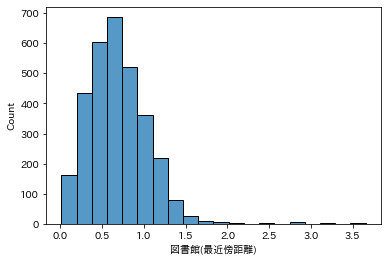

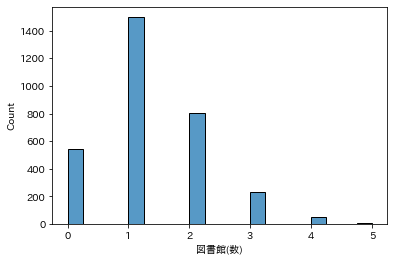

In [20]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [21]:
def rank_score(sr_data):
    rank = sr_data.rank()
    rmax = rank.max()
    rmin = rank.min()
    max_val = 5
    x = (rank - rmin)/(rmax - rmin) * max_val
    return np.clip(x, 0, max_val)

In [22]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

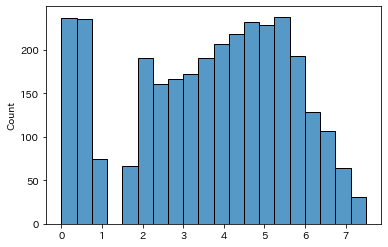

In [23]:
sns.histplot(_tmp_score, bins=20)
plt.show()

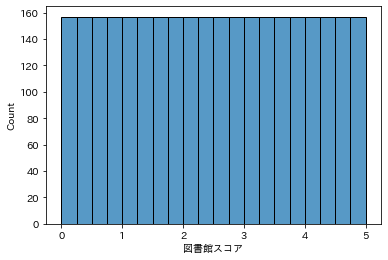

In [24]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [25]:
df_geo_master[score_name].describe()

count    3140.000000
mean        2.500000
std         1.444065
min         0.000000
25%         1.250000
50%         2.500000
75%         3.750000
max         5.000000
Name: 図書館スコア, dtype: float64

### 書店スコア

In [26]:
score_name = '書店スコア'
all_score_list.append(score_name)
feature_list = {
    '書店(最近傍距離)':   {'sort': -1, 'weight': 0.5}, 
    '書店(数)':           {'sort': 1, 'weight': 1}, 
}
all_feature_list += list(feature_list.keys())

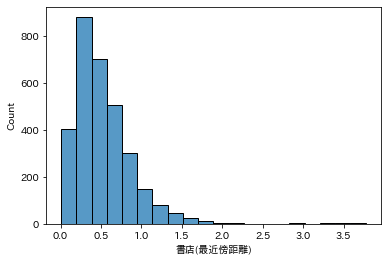

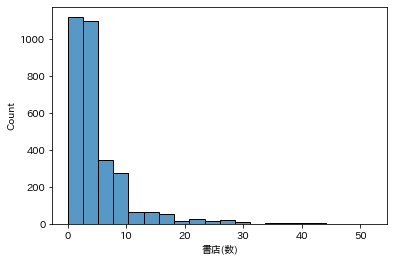

In [27]:
for feature_name in feature_list.keys():
    sns.histplot(df_geo_master[feature_name], bins=20)
    plt.show()

In [28]:
score_list = []
for key, value in feature_list.items():
    df_geo_master[f'{key}レベル'] = rank_score(df_geo_master[key] * value['sort'])
    score_list.append(df_geo_master[f'{key}レベル'] * value['weight'])

_tmp_score = pd.concat(score_list, axis=1).sum(axis=1, skipna=False)
df_geo_master[score_name] = rank_score(_tmp_score)

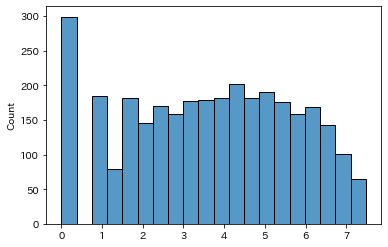

In [29]:
sns.histplot(_tmp_score, bins=20)
plt.show()

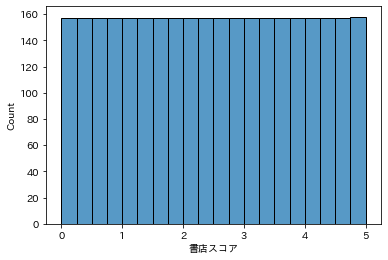

In [30]:
sns.histplot(df_geo_master[score_name], bins=20)
plt.show()

In [31]:
all_score_list

['図書館スコア', '書店スコア']

In [32]:
all_feature_list

['図書館(最近傍距離)', '図書館(数)', '書店(最近傍距離)', '書店(数)']

In [33]:
for score_name in all_score_list:
    df_geo_master[score_name] = df_geo_master[score_name].round(2)
for col in ['図書館(最近傍距離)', '書店(最近傍距離)']:
    df_geo_master[col] = df_geo_master[col].round(3)

### 保存

In [34]:
df_geo_master[
    ['town_id'] + all_feature_list + all_score_list
].to_csv(os.path.join(DIR_NAME, output_score_file), index=False, encoding='utf-8_sig')

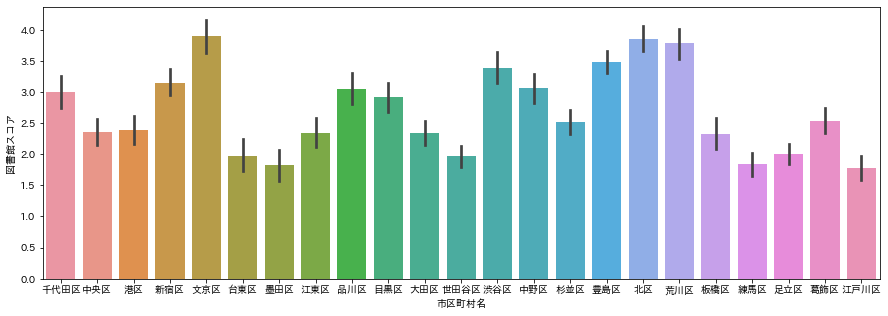

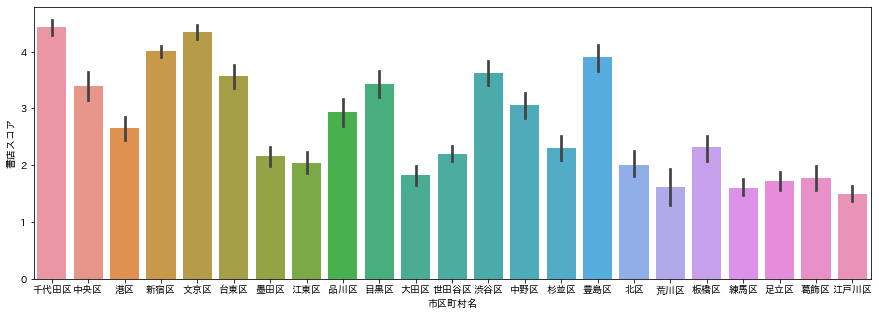

In [35]:
for score_name in all_score_list:
    plt.figure(figsize=(15, 5))
    sns.barplot(x='市区町村名', y=score_name, data=df_geo_master)
    plt.show()

In [36]:
def get_score_top(df_data, target):
    df_level = df_data.copy()
    score_name = f'{target}スコア'
    feature_cols = [col for col in all_feature_list if col.startswith(target)]
    df_level['rank'] = df_level.groupby('町名')[score_name].transform('rank', ascending=False)
    df_level = df_level[df_level['rank'] == 1].sort_values(score_name, ascending=False)[
        ['市区町村名', '町名', '町丁目'] + feature_cols + [score_name]
    ].reset_index(drop=True)
    return df_level

In [37]:
df_level = get_score_top(df_geo_master, '図書館')
print(df_level.shape)
df_level.head(10)

(905, 6)


,市区町村名,町名,町丁目,図書館(最近傍距離),図書館(数),図書館スコア
0,板橋区,本町,本町,0.018,5.0,5.00
1,千代田区,外神田,外神田３丁目,0.057,3.0,5.00
2,北区,東十条,東十条３丁目,0.026,3.0,5.00
3,豊島区,駒込,駒込２丁目,0.075,4.0,5.00
4,板橋区,小豆沢,小豆沢１丁目,0.080,3.0,4.99
5,北区,昭和町,昭和町３丁目,0.093,3.0,4.99
6,北区,上十条,上十条３丁目,0.082,3.0,4.99
7,文京区,本駒込,本駒込４丁目,0.145,4.0,4.99
8,新宿区,大久保,大久保２丁目,0.149,4.0,4.99
9,渋谷区,笹塚,笹塚３丁目,0.156,5.0,4.99


In [38]:
df_level.tail(10)

,市区町村名,町名,町丁目,図書館(最近傍距離),図書館(数),図書館スコア
895,江東区,有明,有明１丁目,1.457,0.0,0.12
896,大田区,東海,東海２丁目,1.477,0.0,0.11
897,中央区,豊海町,豊海町,1.516,0.0,0.09
898,江東区,夢の島,夢の島１丁目,1.753,0.0,0.06
899,練馬区,西大泉町,西大泉町,1.844,0.0,0.05
900,大田区,京浜島,京浜島１丁目,1.860,0.0,0.05
901,江東区,新木場,新木場１丁目,1.910,0.0,0.05
902,品川区,東八潮,東八潮,2.176,0.0,0.04
903,江東区,若洲,若洲１丁目,2.816,0.0,0.02
904,江東区,青海,青海１丁目,2.779,0.0,0.02


In [39]:
df_level = get_score_top(df_geo_master, '書店')
print(df_level.shape)
df_level.head(10)

(898, 6)


,市区町村名,町名,町丁目,書店(最近傍距離),書店(数),書店スコア
0,千代田区,神田錦町,神田錦町２丁目,0.066,39.0,5.00
1,千代田区,神田駿河台,神田駿河台１丁目,0.040,52.0,5.00
2,豊島区,西池袋,西池袋１丁目,0.051,30.0,4.99
3,千代田区,九段南,九段南１丁目,0.054,36.0,4.99
4,千代田区,内神田,内神田３丁目,0.025,25.0,4.98
5,千代田区,神田美土代町,神田美土代町,0.109,39.0,4.98
6,千代田区,神田鍛冶町,神田鍛冶町３丁目,0.027,25.0,4.98
7,豊島区,南池袋,南池袋１丁目,0.057,30.0,4.98
8,豊島区,東池袋,東池袋１丁目,0.075,26.0,4.97
9,千代田区,外神田,外神田１丁目,0.047,23.0,4.97


In [40]:
df_level.tail(10)

,市区町村名,町名,町丁目,書店(最近傍距離),書店(数),書店スコア
888,荒川区,西尾久,西尾久４丁目,1.330,0.0,0.18
889,足立区,六木,六木３丁目,1.357,0.0,0.17
890,板橋区,三園,三園１丁目,1.477,0.0,0.12
891,板橋区,大門,大門,1.539,0.0,0.10
892,葛飾区,水元公園,水元公園,1.640,0.0,0.07
893,足立区,入谷町，舎人町,入谷町，舎人町,1.688,0.0,0.06
894,大田区,東海,東海１丁目,1.811,0.0,0.05
895,江東区,新木場,新木場１丁目,2.098,0.0,0.04
896,江東区,夢の島,夢の島１丁目,1.991,0.0,0.04
897,江東区,若洲,若洲１丁目,2.852,0.0,0.02
